# Import Libraries and Configure GPU

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import os
import re
import logging
from tqdm import tqdm


gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Preventing memory growth issues
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        
        # Using the first available GPU
        tf.config.set_visible_devices(gpus[0], 'GPU')
        print("GPU detected and will be used for training.")
        print("Available GPU:", gpus[0])
    except RuntimeError as e:
        print(e)
else:
    print("No GPU found. Training will be performed on CPU.")


No GPU found. Training will be performed on CPU.


# Data Loading Functions

In [2]:
def load_processed_data(folder_path):
    """
    Load all processed Excel files from a given folder and combine them into a single DataFrame.
    """
    # Ensure the folder exists
    if not os.path.exists(folder_path):
        raise FileNotFoundError(f"The folder {folder_path} does not exist.")

    # Get list of all Excel files in the folder
    files = [file for file in os.listdir(folder_path) if file.endswith('.xlsx')]

    if not files:
        raise ValueError(f"No Excel files found in the folder: {folder_path}")

    # Initialize an empty list to store individual DataFrames
    dataframes = []

    # Read each Excel file and append to the list
    for file in files:
        file_path = os.path.join(folder_path, file)
        try:
            df = pd.read_excel(file_path)
            dataframes.append(df)
        except Exception as e:
            print(f"Error reading file {file_path}: {e}")

    # Concatenate all DataFrames into a single DataFrame
    if dataframes:
        combined_df = pd.concat(dataframes, ignore_index=True)
        print(f"Loaded {len(files)} files with a total of {combined_df.shape[0]} rows.")
        return combined_df
    else:
        raise ValueError("No valid data could be loaded from the folder.")

def load_all_folders(folder_paths):
    """
    Load processed data from multiple folders and combine them into a single DataFrame.
    """
    all_dataframes = []

    for folder_path in folder_paths:
        try:
            print(f"Loading data from folder: {folder_path}")
            df = load_processed_data(folder_path)
            all_dataframes.append(df)
        except Exception as e:
            print(f"Error loading data from folder {folder_path}: {e}")

    # Concatenate all DataFrames from the folders
    if all_dataframes:
        combined_df = pd.concat(all_dataframes, ignore_index=True)
        print(f"Total combined data shape: {combined_df.shape}")
        return combined_df
    else:
        raise ValueError("No valid data could be loaded from the provided folders.")

# Data Processing and Normalization

In [3]:
# Define the sequence length
sequence_length = 30  # Number of points for calculating moving average and integral

# List of training folder paths
train_data_folders = [
    "D:/Uni/Master's/Term1/Fault-Tolerant System Design/Assignments/Replication/code/Dataset1/PCnnLstm/NASA/dataset/5. Battery Data Set/B0030/csv/combined/changed",
    # "/mnt/60FE87C2FE878F4A/Uni/Master's/Term1/Fault-Tolerant System Design/Assignments/Replication/code/Dataset1/5. Battery Data Set/B0031/csv/combined/changed",
    # "/mnt/60FE87C2FE878F4A/Uni/Master's/Term1/Fault-Tolerant System Design/Assignments/Replication/code/Dataset1/5. Battery Data Set/B0032/csv/combined/changed"
]

# List of testing folder paths
test_data_folders = [
    "D:/Uni/Master's/Term1/Fault-Tolerant System Design/Assignments/Replication/code/Dataset1/PCnnLstm/NASA/dataset/5. Battery Data Set/B0029/csv/combined/changed",
]

# Load train and test data from multiple folders
try:
    train_data = load_all_folders(train_data_folders)
    test_data = load_all_folders(test_data_folders)
    print("Train and test data successfully loaded.")
except Exception as e:
    print(f"Error loading data: {e}")

# Define features and target variable
features = [
    'Voltage_measured (Volts)',
    'Current_measured (Amps)',
    # 'Integrated_Current_Window',
    # 'Moving_Average_Voltage',
    # 'Moving_Average_Current',
    # 'Moving_Average_Integrated_Current'
]

target = 'Temperature_measured (C)'

test_original_data = test_data.copy()

# Normalize the data
print("\nNormalizing Data...")
scaler = StandardScaler()
try:
    train_data[features + [target]] = scaler.fit_transform(train_data[features + [target]])
    test_data[features + [target]] = scaler.transform(test_data[features + [target]])
    print("Data normalization complete.")
except Exception as e:
    print(f"Error during normalization: {e}")
    raise


# Reset index after concatenation
train_data.reset_index(drop=True, inplace=True)
test_data.reset_index(drop=True, inplace=True)

Loading data from folder: D:/Uni/Master's/Term1/Fault-Tolerant System Design/Assignments/Replication/code/Dataset1/PCnnLstm/NASA/dataset/5. Battery Data Set/B0030/csv/combined/changed
Loaded 16 files with a total of 109559 rows.
Total combined data shape: (109559, 11)
Loading data from folder: D:/Uni/Master's/Term1/Fault-Tolerant System Design/Assignments/Replication/code/Dataset1/PCnnLstm/NASA/dataset/5. Battery Data Set/B0029/csv/combined/changed
Loaded 16 files with a total of 109559 rows.
Total combined data shape: (109559, 11)
Train and test data successfully loaded.

Normalizing Data...
Data normalization complete.


# Sequence Creation and Dataset Preparation

In [4]:
# Function to create sequences from data
def create_sequences(data, features, target, sequence_length):
    """
    Creates sequences of data for model training/testing.
    """
    X, y = [], []
    source_files = []
    for i in tqdm(range(len(data) - sequence_length), desc="Creating Sequences", unit="sequence"):
        X.append(data[features].iloc[i:i + sequence_length].values)
        y.append(data[target].iloc[i + sequence_length])
        source_files.append(data["Source_File"].iloc[i + sequence_length])
    return np.array(X), np.array(y), np.array(source_files)


def create_sequences_original(data, features, sequence_length):
    """
    Creates sequences of raw data for testing (no normalization applied).
    """
    X, y = [], []
    for i in tqdm(range(len(data) - sequence_length), desc="Creating Sequences", unit="sequence"):
        X.append(data[features].iloc[i:i + sequence_length].values)
        y.append(data[target].iloc[i + sequence_length])

    return np.array(X), np.array(y)


# Function to create sequences and save/load them
def prepare_sequences(data, features, target, sequence_length, dataset_type='train'):
    """
    Prepares sequences for model training or testing.
    """
    X, y, source_files = create_sequences(data, features, target, sequence_length)
    # Save the data for later use
    np.save(f'../npy_files/X_{dataset_type}.npy', X)
    np.save(f'../npy_files/y_{dataset_type}.npy', y)
    np.save(f'../npy_files/source_files_{dataset_type}.npy', source_files)
    print(f"{dataset_type.capitalize()} sequences created and saved.")
    return X, y, source_files

# Prepare training sequences
print("\nPreparing Training Sequences...")
if os.path.exists('../npy_files/X_train.npy') and os.path.exists('../npy_files/y_train.npy'):
    print("Loading train data from files...")
    X_train = np.load('../npy_files/X_train.npy')
    y_train = np.load('../npy_files/y_train.npy')
    source_files_train = np.load('../npy_files/source_files_train.npy')
else:
    X_train, y_train, source_files_train = prepare_sequences(train_data, features, target, sequence_length, dataset_type='train')

# Prepare testing sequences
print("\nPreparing Testing Sequences...")
if os.path.exists('../npy_files/X_test.npy') and os.path.exists('../npy_files/y_test.npy'):
    print("Loading test data from files...")
    X_test = np.load('../npy_files/X_test.npy')
    y_test = np.load('../npy_files/y_test.npy')
    source_files_test = np.load('../npy_files/source_files_test.npy')
else:
    X_test, y_test, source_files_test = prepare_sequences(test_data, features, target, sequence_length, dataset_type='test')


print("\nPreparing Original Testing Sequences...")
if os.path.exists('../npy_files/X_test_original.npy') and os.path.exists('../npy_files/y_test_original.npy'):
    print("Loading original test data from files...")
    X_test_original = np.load('../npy_files/X_test_original.npy')
    y_test_original = np.load('../npy_files/y_test_original.npy')
else:
    X_test_original, y_test_original = create_sequences_original(test_original_data, features, sequence_length)
    np.save('../npy_files/X_test_original.npy', X_test_original)
    np.save('../npy_files/y_test_original.npy', y_test_original)

# Create TensorFlow datasets
print("\nCreating TensorFlow Datasets...")
batch_size = 32

print(len(X_train))
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=10000).batch(batch_size)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = test_dataset.batch(batch_size)

print("Training and testing datasets are ready for modeling.")


Preparing Training Sequences...
Loading train data from files...

Preparing Testing Sequences...
Loading test data from files...

Preparing Original Testing Sequences...
Loading original test data from files...

Creating TensorFlow Datasets...
328647
Training and testing datasets are ready for modeling.


# PCNN-LSTM Model Definition

In [5]:
# Define the model architecture
def build_pcnn_lstm_model(input_shape, output_size=1):
    inputs = layers.Input(shape=input_shape)  # (seq_len, input_size)

    # CNN Branch
    x_cnn = layers.Conv1D(filters=16, kernel_size=3, activation='relu')(inputs)
    x_cnn = layers.BatchNormalization()(x_cnn)
    x_cnn = layers.MaxPooling1D(pool_size=2, strides=1)(x_cnn)
    x_cnn = layers.Flatten()(x_cnn)  # (batch_size, features)

    # LSTM Branch
    x_lstm = layers.LSTM(200, return_sequences=True, activation='tanh', recurrent_activation='sigmoid', unroll=True)(inputs)
    x_lstm = layers.BatchNormalization()(x_lstm)
    x_lstm = layers.LSTM(100, activation='tanh', recurrent_activation='sigmoid', unroll=True)(x_lstm)

    # Concatenate CNN and LSTM branches
    x = layers.concatenate([x_cnn, x_lstm])  # Flatten already handled

    # Fully Connected Layers
    x = layers.Dense(200, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(100, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(100, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(output_size)(x)  # For regression

    model = models.Model(inputs=inputs, outputs=outputs)
    return model

input_shape = (sequence_length, len(features))
output_size = 1  # For regression

model = build_pcnn_lstm_model(input_shape)
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae', tf.keras.metrics.RootMeanSquaredError(name='rmse')]
)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 30, 2)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 28, 16)    │        112 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 28, 16)    │         64 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 30, 200)   │    162,400 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 27, 16)    │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 30, 200)   │        800 │ lstm[0][0]        │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 432)       │          0 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 100)       │    120,400 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 532)       │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 200)       │    106,600 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 200)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 100)       │     20,100 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 100)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 100)       │     10,100 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 100)       │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │        101 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 420,677 (1.60 MB)

 Trainable params: 420,245 (1.60 MB)

 Non-trainable params: 432 (1.69 KB)

# Model Training and Callbacks

In [6]:
# Configure logging to output to both console and file
logging.basicConfig(
    level=logging.INFO,
    format='%(message)s',
    handlers=[
        logging.FileHandler("./PCnnLstm_training_log.txt"),  # Save output to file
        logging.StreamHandler()  # Also display output in console
    ]
)
logger = logging.getLogger()

# File to save the last epoch
last_epoch_file = "./last_epoch.txt"

# Custom callback to log detailed epoch information
class LoggingCallback(callbacks.Callback):
    def on_train_begin(self, logs=None):
        logger.info("Training started.")

    def on_epoch_end(self, epoch, logs=None):
        if logs:
            log_message = f"Epoch {epoch + 1}/{self.params['epochs']} completed."
            for key, value in logs.items():
                log_message += f" - {key}: {value:.4f}"
            logger.info(log_message)
        else:
            logger.info(f"Epoch {epoch + 1}/{self.params['epochs']} completed.")
        logger.info("\n")
    def on_train_end(self, logs=None):
        logger.info("Training completed.")

# Custom callback to log saving model
class CustomModelCheckpoint(callbacks.ModelCheckpoint):
    def on_epoch_end(self, epoch, logs=None):
        super().on_epoch_end(epoch, logs)
        if logs and self.best == logs.get('loss'):
            logger.info(
                f"Epoch {epoch + 1}: loss improved to {logs['loss']:.4f}, saving model to {self.filepath}."
            )
            # Save the last completed epoch
            with open(last_epoch_file, "w") as f:
                f.write(str(epoch + 1))  # Save the next epoch to start from

# Load checkpoint if exists
checkpoint_path = "./PCnnLstm_checkpoint.keras"
initial_epoch = 0
if os.path.exists(checkpoint_path):
    model.load_weights(checkpoint_path)
    logger.info("Checkpoint loaded. Resuming training...")
    if os.path.exists(last_epoch_file):
        with open(last_epoch_file, "r") as f:
            initial_epoch = int(f.read().strip())
        logger.info(f"Resuming training from epoch {initial_epoch}.")
else:
    logger.warning("No checkpoint found. Training will start from scratch.")

# Initialize callbacks
checkpoint_callback = CustomModelCheckpoint(
    filepath=checkpoint_path,
    monitor='loss',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

early_stopping_callback = callbacks.EarlyStopping(
    monitor='loss',
    patience=20,
    restore_best_weights=True,
    verbose=1
)

# Train the model
history = model.fit(
    train_dataset,
    epochs=40,
    initial_epoch=initial_epoch,  # Start from the last saved epoch
    callbacks=[checkpoint_callback, early_stopping_callback, LoggingCallback()],
    verbose=1
)

# Log the final history
logger.info("Final Training History:")
for key, values in history.history.items():
    logger.info(f"{key}: {values}")


No checkpoint found. Training will start from scratch.
Training started.


Epoch 1/40


I0000 00:00:1736111457.866390    5197 service.cc:148] XLA service 0x79e194013bb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1736111457.866411    5197 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1650 Ti, Compute Capability 7.5
2025-01-06 00:40:58.156940: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1736111460.381080    5197 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-01-06 00:41:06.242342: W external/local_xla/xla/service/gpu/nvptx_compiler.cc:930] The NVIDIA driver's CUDA version is 12.4 which is older than the PTX compiler version 12.5.82. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


  20/1202 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 1.3809 - mae: 0.7072 - rmse: 1.1702 

I0000 00:00:1736111471.085338    5197 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1202/1202 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.3773 - mae: 0.3158 - rmse: 0.6009
Epoch 1: loss improved from inf to 0.23154, saving model to ./PCnnLstm_checkpoint.keras


Epoch 1: loss improved to 0.2315, saving model to ./PCnnLstm_checkpoint.keras.
Epoch 1/40 completed. - loss: 0.2315 - mae: 0.2424 - rmse: 0.4812




1202/1202 ━━━━━━━━━━━━━━━━━━━━ 45s 19ms/step - loss: 0.3772 - mae: 0.3157 - rmse: 0.6008
Epoch 2/40
1195/1202 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1174 - mae: 0.1767 - rmse: 0.3425
Epoch 2: loss improved from 0.23154 to 0.12220, saving model to ./PCnnLstm_checkpoint.keras


Epoch 2: loss improved to 0.1222, saving model to ./PCnnLstm_checkpoint.keras.
Epoch 2/40 completed. - loss: 0.1222 - mae: 0.1757 - rmse: 0.3496




1202/1202 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.1174 - mae: 0.1767 - rmse: 0.3425
Epoch 3/40
1201/1202 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0926 - mae: 0.1586 - rmse: 0.3041
Epoch 3: loss improved from 0.12220 to 0.09926, saving model to ./PCnnLstm_checkpoint.keras


Epoch 3: loss improved to 0.0993, saving model to ./PCnnLstm_checkpoint.keras.
Epoch 3/40 completed. - loss: 0.0993 - mae: 0.1594 - rmse: 0.3150




1202/1202 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.0926 - mae: 0.1586 - rmse: 0.3041
Epoch 4/40
1198/1202 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0911 - mae: 0.1565 - rmse: 0.3016
Epoch 4: loss improved from 0.09926 to 0.09313, saving model to ./PCnnLstm_checkpoint.keras


Epoch 4: loss improved to 0.0931, saving model to ./PCnnLstm_checkpoint.keras.
Epoch 4/40 completed. - loss: 0.0931 - mae: 0.1547 - rmse: 0.3052




1202/1202 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.0911 - mae: 0.1565 - rmse: 0.3016
Epoch 5/40
1198/1202 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0844 - mae: 0.1513 - rmse: 0.2901
Epoch 5: loss improved from 0.09313 to 0.08828, saving model to ./PCnnLstm_checkpoint.keras


Epoch 5: loss improved to 0.0883, saving model to ./PCnnLstm_checkpoint.keras.
Epoch 5/40 completed. - loss: 0.0883 - mae: 0.1524 - rmse: 0.2971




1202/1202 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 0.0844 - mae: 0.1513 - rmse: 0.2901
Epoch 6/40
1196/1202 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0764 - mae: 0.1454 - rmse: 0.2763
Epoch 6: loss improved from 0.08828 to 0.07960, saving model to ./PCnnLstm_checkpoint.keras


Epoch 6: loss improved to 0.0796, saving model to ./PCnnLstm_checkpoint.keras.
Epoch 6/40 completed. - loss: 0.0796 - mae: 0.1459 - rmse: 0.2821




1202/1202 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 0.0764 - mae: 0.1454 - rmse: 0.2763
Epoch 7/40
1196/1202 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0680 - mae: 0.1399 - rmse: 0.2604
Epoch 7: loss improved from 0.07960 to 0.07396, saving model to ./PCnnLstm_checkpoint.keras


Epoch 7: loss improved to 0.0740, saving model to ./PCnnLstm_checkpoint.keras.
Epoch 7/40 completed. - loss: 0.0740 - mae: 0.1424 - rmse: 0.2720




1202/1202 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 0.0680 - mae: 0.1400 - rmse: 0.2605
Epoch 8/40
1199/1202 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0658 - mae: 0.1365 - rmse: 0.2563
Epoch 8: loss improved from 0.07396 to 0.07149, saving model to ./PCnnLstm_checkpoint.keras


Epoch 8: loss improved to 0.0715, saving model to ./PCnnLstm_checkpoint.keras.
Epoch 8/40 completed. - loss: 0.0715 - mae: 0.1400 - rmse: 0.2674




1202/1202 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 0.0658 - mae: 0.1365 - rmse: 0.2563
Epoch 9/40
1199/1202 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0609 - mae: 0.1353 - rmse: 0.2467
Epoch 9: loss improved from 0.07149 to 0.06500, saving model to ./PCnnLstm_checkpoint.keras


Epoch 9: loss improved to 0.0650, saving model to ./PCnnLstm_checkpoint.keras.
Epoch 9/40 completed. - loss: 0.0650 - mae: 0.1363 - rmse: 0.2549




1202/1202 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.0609 - mae: 0.1353 - rmse: 0.2467
Epoch 10/40
1196/1202 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0586 - mae: 0.1329 - rmse: 0.2421
Epoch 10: loss improved from 0.06500 to 0.06035, saving model to ./PCnnLstm_checkpoint.keras


Epoch 10: loss improved to 0.0604, saving model to ./PCnnLstm_checkpoint.keras.
Epoch 10/40 completed. - loss: 0.0604 - mae: 0.1316 - rmse: 0.2457




1202/1202 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.0587 - mae: 0.1329 - rmse: 0.2421
Epoch 11/40
1200/1202 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0556 - mae: 0.1275 - rmse: 0.2355
Epoch 11: loss did not improve from 0.06035


Epoch 11/40 completed. - loss: 0.0611 - mae: 0.1304 - rmse: 0.2471




1202/1202 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.0556 - mae: 0.1275 - rmse: 0.2355
Epoch 12/40
1197/1202 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0549 - mae: 0.1306 - rmse: 0.2342
Epoch 12: loss improved from 0.06035 to 0.05819, saving model to ./PCnnLstm_checkpoint.keras


Epoch 12: loss improved to 0.0582, saving model to ./PCnnLstm_checkpoint.keras.
Epoch 12/40 completed. - loss: 0.0582 - mae: 0.1312 - rmse: 0.2412




1202/1202 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.0549 - mae: 0.1306 - rmse: 0.2342
Epoch 13/40
1201/1202 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0533 - mae: 0.1266 - rmse: 0.2306
Epoch 13: loss did not improve from 0.05819


Epoch 13/40 completed. - loss: 0.0597 - mae: 0.1305 - rmse: 0.2444




1202/1202 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.0533 - mae: 0.1267 - rmse: 0.2307
Epoch 14/40
1199/1202 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0544 - mae: 0.1281 - rmse: 0.2330
Epoch 14: loss improved from 0.05819 to 0.05727, saving model to ./PCnnLstm_checkpoint.keras


Epoch 14: loss improved to 0.0573, saving model to ./PCnnLstm_checkpoint.keras.
Epoch 14/40 completed. - loss: 0.0573 - mae: 0.1290 - rmse: 0.2393




1202/1202 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.0544 - mae: 0.1281 - rmse: 0.2330
Epoch 15/40
1200/1202 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0534 - mae: 0.1252 - rmse: 0.2306
Epoch 15: loss did not improve from 0.05727


Epoch 15/40 completed. - loss: 0.0578 - mae: 0.1288 - rmse: 0.2404




1202/1202 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.0534 - mae: 0.1252 - rmse: 0.2307
Epoch 16/40
1200/1202 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0541 - mae: 0.1282 - rmse: 0.2323
Epoch 16: loss did not improve from 0.05727


Epoch 16/40 completed. - loss: 0.0617 - mae: 0.1313 - rmse: 0.2485




1202/1202 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.0542 - mae: 0.1282 - rmse: 0.2323
Epoch 17/40
1202/1202 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0598 - mae: 0.1326 - rmse: 0.2443
Epoch 17: loss did not improve from 0.05727


Epoch 17/40 completed. - loss: 0.0603 - mae: 0.1324 - rmse: 0.2456




1202/1202 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 0.0598 - mae: 0.1326 - rmse: 0.2443
Epoch 18/40
1198/1202 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0574 - mae: 0.1294 - rmse: 0.2395
Epoch 18: loss did not improve from 0.05727


Epoch 18/40 completed. - loss: 0.0594 - mae: 0.1300 - rmse: 0.2438




1202/1202 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 0.0574 - mae: 0.1294 - rmse: 0.2395
Epoch 19/40
1202/1202 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0494 - mae: 0.1241 - rmse: 0.2221
Epoch 19: loss improved from 0.05727 to 0.05463, saving model to ./PCnnLstm_checkpoint.keras


Epoch 19: loss improved to 0.0546, saving model to ./PCnnLstm_checkpoint.keras.
Epoch 19/40 completed. - loss: 0.0546 - mae: 0.1267 - rmse: 0.2337




1202/1202 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.0494 - mae: 0.1241 - rmse: 0.2221
Epoch 20/40
1197/1202 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0517 - mae: 0.1233 - rmse: 0.2272
Epoch 20: loss improved from 0.05463 to 0.05423, saving model to ./PCnnLstm_checkpoint.keras


Epoch 20: loss improved to 0.0542, saving model to ./PCnnLstm_checkpoint.keras.
Epoch 20/40 completed. - loss: 0.0542 - mae: 0.1249 - rmse: 0.2329




1202/1202 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.0517 - mae: 0.1233 - rmse: 0.2272
Epoch 21/40
1200/1202 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0510 - mae: 0.1254 - rmse: 0.2257
Epoch 21: loss improved from 0.05423 to 0.05360, saving model to ./PCnnLstm_checkpoint.keras


Epoch 21: loss improved to 0.0536, saving model to ./PCnnLstm_checkpoint.keras.
Epoch 21/40 completed. - loss: 0.0536 - mae: 0.1255 - rmse: 0.2315




1202/1202 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.0510 - mae: 0.1254 - rmse: 0.2258
Epoch 22/40
1199/1202 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0475 - mae: 0.1231 - rmse: 0.2178
Epoch 22: loss improved from 0.05360 to 0.05240, saving model to ./PCnnLstm_checkpoint.keras


Epoch 22: loss improved to 0.0524, saving model to ./PCnnLstm_checkpoint.keras.
Epoch 22/40 completed. - loss: 0.0524 - mae: 0.1248 - rmse: 0.2289




1202/1202 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.0475 - mae: 0.1231 - rmse: 0.2178
Epoch 23/40
1202/1202 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0525 - mae: 0.1248 - rmse: 0.2289
Epoch 23: loss did not improve from 0.05240


Epoch 23/40 completed. - loss: 0.0571 - mae: 0.1277 - rmse: 0.2390




1202/1202 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.0525 - mae: 0.1248 - rmse: 0.2289
Epoch 24/40
1196/1202 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0495 - mae: 0.1240 - rmse: 0.2223
Epoch 24: loss improved from 0.05240 to 0.05233, saving model to ./PCnnLstm_checkpoint.keras


Epoch 24: loss improved to 0.0523, saving model to ./PCnnLstm_checkpoint.keras.
Epoch 24/40 completed. - loss: 0.0523 - mae: 0.1243 - rmse: 0.2288




1202/1202 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.0495 - mae: 0.1240 - rmse: 0.2223
Epoch 25/40
1202/1202 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0488 - mae: 0.1228 - rmse: 0.2207
Epoch 25: loss improved from 0.05233 to 0.05000, saving model to ./PCnnLstm_checkpoint.keras


Epoch 25: loss improved to 0.0500, saving model to ./PCnnLstm_checkpoint.keras.
Epoch 25/40 completed. - loss: 0.0500 - mae: 0.1225 - rmse: 0.2236




1202/1202 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.0488 - mae: 0.1228 - rmse: 0.2207
Epoch 26/40
1197/1202 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0491 - mae: 0.1222 - rmse: 0.2215
Epoch 26: loss did not improve from 0.05000


Epoch 26/40 completed. - loss: 0.0516 - mae: 0.1243 - rmse: 0.2272




1202/1202 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 0.0491 - mae: 0.1222 - rmse: 0.2215
Epoch 27/40
1196/1202 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0500 - mae: 0.1230 - rmse: 0.2233
Epoch 27: loss did not improve from 0.05000


Epoch 27/40 completed. - loss: 0.0547 - mae: 0.1265 - rmse: 0.2338




1202/1202 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.0500 - mae: 0.1230 - rmse: 0.2233
Epoch 28/40
1199/1202 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0466 - mae: 0.1207 - rmse: 0.2158
Epoch 28: loss did not improve from 0.05000


Epoch 28/40 completed. - loss: 0.0503 - mae: 0.1229 - rmse: 0.2243




1202/1202 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 0.0466 - mae: 0.1207 - rmse: 0.2158
Epoch 29/40
1200/1202 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0478 - mae: 0.1214 - rmse: 0.2185
Epoch 29: loss did not improve from 0.05000


Epoch 29/40 completed. - loss: 0.0514 - mae: 0.1233 - rmse: 0.2267




1202/1202 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 0.0478 - mae: 0.1214 - rmse: 0.2185
Epoch 30/40
1200/1202 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0484 - mae: 0.1230 - rmse: 0.2198
Epoch 30: loss did not improve from 0.05000


Epoch 30/40 completed. - loss: 0.0504 - mae: 0.1232 - rmse: 0.2245




1202/1202 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 0.0484 - mae: 0.1230 - rmse: 0.2198
Epoch 31/40
1196/1202 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0456 - mae: 0.1192 - rmse: 0.2133
Epoch 31: loss did not improve from 0.05000


Epoch 31/40 completed. - loss: 0.0512 - mae: 0.1234 - rmse: 0.2263




1202/1202 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 0.0457 - mae: 0.1192 - rmse: 0.2134
Epoch 32/40
1197/1202 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0503 - mae: 0.1254 - rmse: 0.2241
Epoch 32: loss did not improve from 0.05000


Epoch 32/40 completed. - loss: 0.0525 - mae: 0.1239 - rmse: 0.2290




1202/1202 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 0.0503 - mae: 0.1254 - rmse: 0.2241
Epoch 33/40
1196/1202 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0458 - mae: 0.1193 - rmse: 0.2137
Epoch 33: loss improved from 0.05000 to 0.04973, saving model to ./PCnnLstm_checkpoint.keras


Epoch 33: loss improved to 0.0497, saving model to ./PCnnLstm_checkpoint.keras.
Epoch 33/40 completed. - loss: 0.0497 - mae: 0.1220 - rmse: 0.2230




1202/1202 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.0458 - mae: 0.1193 - rmse: 0.2138
Epoch 34/40
1201/1202 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0484 - mae: 0.1220 - rmse: 0.2199
Epoch 34: loss did not improve from 0.04973


Epoch 34/40 completed. - loss: 0.0502 - mae: 0.1224 - rmse: 0.2240




1202/1202 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 0.0484 - mae: 0.1220 - rmse: 0.2200
Epoch 35/40
1196/1202 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0483 - mae: 0.1213 - rmse: 0.2194
Epoch 35: loss did not improve from 0.04973


Epoch 35/40 completed. - loss: 0.0529 - mae: 0.1239 - rmse: 0.2299




1202/1202 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.0483 - mae: 0.1213 - rmse: 0.2195
Epoch 36/40
1201/1202 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0468 - mae: 0.1206 - rmse: 0.2161
Epoch 36: loss improved from 0.04973 to 0.04952, saving model to ./PCnnLstm_checkpoint.keras


Epoch 36: loss improved to 0.0495, saving model to ./PCnnLstm_checkpoint.keras.
Epoch 36/40 completed. - loss: 0.0495 - mae: 0.1218 - rmse: 0.2225




1202/1202 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.0468 - mae: 0.1206 - rmse: 0.2161
Epoch 37/40
1196/1202 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0453 - mae: 0.1192 - rmse: 0.2126
Epoch 37: loss improved from 0.04952 to 0.04801, saving model to ./PCnnLstm_checkpoint.keras


Epoch 37: loss improved to 0.0480, saving model to ./PCnnLstm_checkpoint.keras.
Epoch 37/40 completed. - loss: 0.0480 - mae: 0.1204 - rmse: 0.2191




1202/1202 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 0.0453 - mae: 0.1192 - rmse: 0.2127
Epoch 38/40
1198/1202 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0464 - mae: 0.1191 - rmse: 0.2154
Epoch 38: loss did not improve from 0.04801


Epoch 38/40 completed. - loss: 0.0486 - mae: 0.1195 - rmse: 0.2206




1202/1202 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 0.0464 - mae: 0.1191 - rmse: 0.2154
Epoch 39/40
1202/1202 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0460 - mae: 0.1196 - rmse: 0.2144
Epoch 39: loss did not improve from 0.04801


Epoch 39/40 completed. - loss: 0.0489 - mae: 0.1212 - rmse: 0.2212




1202/1202 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.0460 - mae: 0.1196 - rmse: 0.2144
Epoch 40/40
1201/1202 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0467 - mae: 0.1209 - rmse: 0.2160
Epoch 40: loss did not improve from 0.04801


Epoch 40/40 completed. - loss: 0.0484 - mae: 0.1204 - rmse: 0.2199




1202/1202 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.0467 - mae: 0.1209 - rmse: 0.2160
Restoring model weights from the end of the best epoch: 37.


Training completed.
Final Training History:
loss: [0.23153646290302277, 0.1221994012594223, 0.09925500303506851, 0.09312862902879715, 0.08828382194042206, 0.07960487902164459, 0.07396125793457031, 0.0714886337518692, 0.0649990513920784, 0.06035305932164192, 0.061056021600961685, 0.05819053575396538, 0.059738874435424805, 0.057270780205726624, 0.05779268965125084, 0.06173909455537796, 0.06031126528978348, 0.05944479629397392, 0.05462547391653061, 0.05422680079936981, 0.053596168756484985, 0.052399806678295135, 0.05710764229297638, 0.052329856902360916, 0.050002291798591614, 0.05163131281733513, 0.05465894192457199, 0.05029773339629173, 0.051384322345256805, 0.05037866160273552, 0.051229268312454224, 0.052462559193372726, 0.04973318427801132, 0.05018221214413643, 0.052869394421577454, 0.04952070116996765, 0.04800591990351677, 0.04864947125315666, 0.04893636330962181, 0.048357125371694565]
mae: [0.2423907071352005, 0.17566189169883728, 0.15944601595401764, 0.15472780168056488, 0.152420461

# ESP32 Integration and Progress Tracking

In [6]:
import serial
import pickle

# Path to store progress
progress_file = "./progress_data.pkl"


# Load previous progress if available
if os.path.exists(progress_file):
    with open(progress_file, "rb") as f:
        progress_data = pickle.load(f)
        start_index = progress_data.get("last_index", 0)
        esp_preds_scaled = progress_data.get("esp_preds_scaled", [])
        model_preds_scaled = progress_data.get("model_preds_scaled", [])
        labels_scaled = progress_data.get("labels_scaled", [])
else:
    start_index = 0
    esp_preds_scaled = []
    model_preds_scaled = []
    labels_scaled = []

run_on_esp = False

if run_on_esp:
    # Serial connection settings for ESP32
    ESP32_PORT = "/dev/ttyACM0"  # Adjust based on your system
    BAUD_RATE = 115200
    esp = serial.Serial(ESP32_PORT, BAUD_RATE, timeout=5)

    # Process data
    for i, sequence in enumerate(tqdm(X_test[start_index:], desc="Processing Data", unit="sequence", initial=start_index, total=len(X_test))):
        index = i + start_index  # Adjust index relative to the full dataset

        # ===========================
        # 1) Model prediction in Python
        # ===========================
        sequence_expanded = np.expand_dims(sequence, axis=0)
        local_pred = model.predict(sequence_expanded, verbose=0)  # Shape: (1, 1)
        local_pred_val = local_pred[0, 0]  # Extract the predicted value (normalized scale)

        model_preds_scaled.append(local_pred_val)
        labels_scaled.append(y_test[index])  # Append the true value (normalized scale)

        # ===========================
        # 2) Send data to ESP32
        # ===========================
        flattened = sequence.flatten()
        payload = ",".join(map(str, flattened))
        max_retries = 3  # Maximum number of retries
        retries = 0
        esp_pred_val = np.nan  # Default value in case of failure

        while retries < max_retries:
            try:
                esp.write((payload + "\n").encode())

                raw_response = esp.readline()
                response = raw_response.decode().strip()
                match = re.search(r"Predicted Temperature:\s*(-?\d*\.\d+|-?\d+)", response)

                if match:
                    esp_pred_val = float(match.group(1))
                    break  # Exit the loop if successful
                else:
                    raise ValueError(f"No numeric value found in response: {response}")

            except Exception as e:
                retries += 1
                print(f"Error decoding ESP32 response for sample {index + 1}, attempt {retries}: {e}. Raw response: {raw_response}")

        if retries == max_retries:
            print(f"Failed to get valid response from ESP32 for sample {index + 1} after {max_retries} attempts.")
            
        esp_preds_scaled.append(esp_pred_val)

        # ===========================
        # Save progress
        # ===========================
        progress_data = {
            "last_index": index + 1,
            "esp_preds_scaled": esp_preds_scaled,
            "model_preds_scaled": model_preds_scaled,
            "labels_scaled": labels_scaled,
        }
        with open(progress_file, "wb") as f:
            pickle.dump(progress_data, f)

    # Close ESP32 connection
    esp.close()


# Output Creation, Comparison, and Visualization

Comparison file with highlighted errors saved: ./result_1\Comparison_ESP32_vs_Model.xlsx


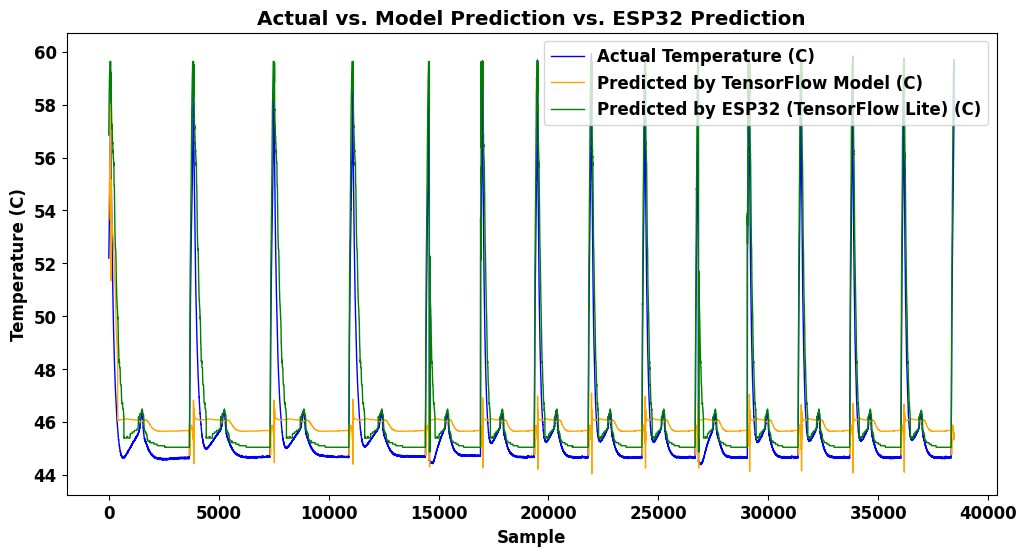

C:\Users\user\AppData\Local\Temp\ipykernel_3732\2999160129.py:144: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


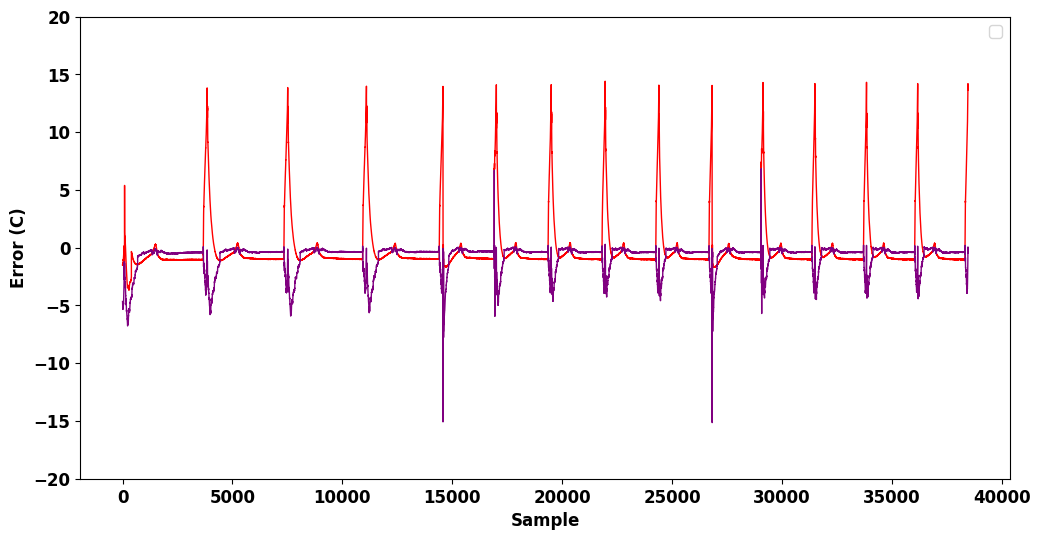

Model MAE: 1.42, RMSE: 2.49
ESP32 MAE: 0.79, RMSE: 1.41


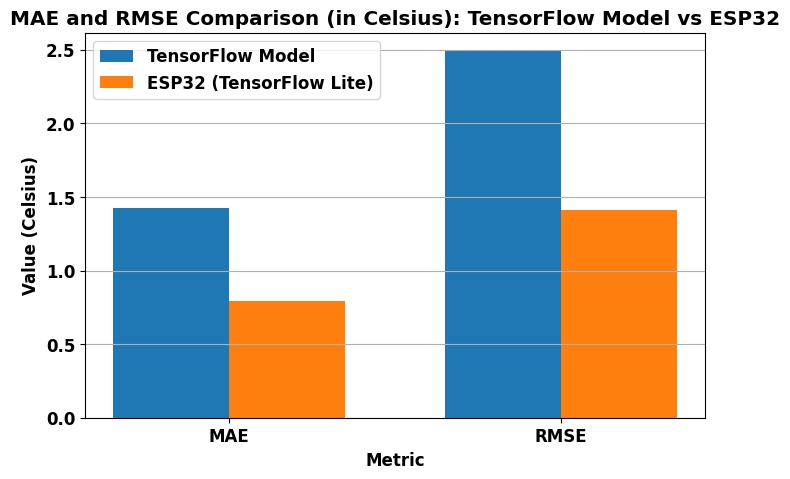

In [9]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from openpyxl import load_workbook
from openpyxl.styles import PatternFill
from sklearn.metrics import mean_absolute_error, mean_squared_error

# -------------------------
# Matplotlib settings for high-quality images and bold text
# -------------------------
plt.rcParams['figure.dpi'] = 100  # DPI for preview
plt.rcParams['savefig.dpi'] = 1000  # DPI for saving figures (adjust if needed)
plt.rcParams['font.size'] = 12     # Default font size
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.labelweight'] = 'bold'
# -------------------------


# Set the base output directory name and counter for results
result_number = 1
directory_name = f"./result_{result_number}"

# Ensure the output directory exists
if not os.path.exists(directory_name):
    os.makedirs(directory_name)

# Assume the following variables are pre-defined:
# labels_scaled, model_preds_scaled, esp_preds_scaled, features, scaler

# Reshape scaled labels and predictions into column vectors
labels_scaled_arr = np.array(labels_scaled).reshape(-1, 1)
model_preds_scaled_arr = np.array(model_preds_scaled).reshape(-1, 1)
esp_preds_scaled_arr = np.array(esp_preds_scaled).reshape(-1, 1)

# Create zero placeholders for feature inversion
num_features = len(features)
zeros_for_features = np.zeros((len(labels_scaled_arr), num_features))

# Inverse transform to obtain original temperature values
labels_original = scaler.inverse_transform(np.hstack([zeros_for_features, labels_scaled_arr]))[:, -1]
model_preds_original = scaler.inverse_transform(np.hstack([zeros_for_features, model_preds_scaled_arr]))[:, -1]
esp_preds_original = scaler.inverse_transform(np.hstack([zeros_for_features, esp_preds_scaled_arr]))[:, -1]

# ==============================
# Create a comparison DataFrame
# ==============================
n = len(labels_original)  # or len(comparison_df)
sequence_length = 30  # Length of your LSTM sequence

voltages = []
currents = []

for i in range(n):
    # The row in the main dataframe from which the label is taken
    row_idx = i + sequence_length
    
    # If the row index is within the bounds of the dataframe
    if row_idx < len(test_original_data):
        voltages.append(
            test_original_data["Voltage_measured (Volts)"].iloc[row_idx]
        )
        currents.append(
            test_original_data["Current_measured (Amps)"].iloc[row_idx]
        )
    else:
        # In case we have reached the end of the dataframe and there is no row
        voltages.append(np.nan)
        currents.append(np.nan)

# ---- Now, form the dataframe or add new columns:
comparison_df = pd.DataFrame({
    "Sample_Index": range(1, len(labels_original) + 1),
    "Actual (C)": labels_original,
    "Model_Pred (C)": model_preds_original,
    "ESP_Pred (C)": esp_preds_original,
})

comparison_df["Voltage"] = voltages
comparison_df["Current"] = currents

comparison_df["Error_Model"] = comparison_df["Actual (C)"] - comparison_df["Model_Pred (C)"]
comparison_df["Error_ESP"] = comparison_df["Actual (C)"] - comparison_df["ESP_Pred (C)"]

# ==============================
# Save the comparison DataFrame to an Excel file
# ==============================
excel_file = os.path.join(directory_name, "Comparison_ESP32_vs_Model.xlsx")
comparison_df.to_excel(excel_file, index=False)

# Load the saved Excel file
wb = load_workbook(excel_file)
ws = wb.active

# Define the red fill style
red_fill = PatternFill(start_color="FF0000", end_color="FF0000", fill_type="solid")

# Get column indexes for "Error_Model" and "Error_ESP"
error_model_col = comparison_df.columns.get_loc("Error_Model") + 1  # Convert to 1-based index
error_esp_col = comparison_df.columns.get_loc("Error_ESP") + 1  # Convert to 1-based index

# Iterate over rows and highlight errors greater than 5 in red
for row in ws.iter_rows(min_row=2, max_row=ws.max_row):
    error_model_value = row[error_model_col - 1].value  # Adjust for 1-based index
    error_esp_value = row[error_esp_col - 1].value  # Adjust for 1-based index

    # Ensure the values are not None before applying abs()
    if error_model_value is not None and abs(error_model_value) > 5:
        row[error_model_col - 1].fill = red_fill  # Highlight "Error_Model"

    if error_esp_value is not None and abs(error_esp_value) > 5:
        row[error_esp_col - 1].fill = red_fill  # Highlight "Error_ESP"

# Save the modified file
wb.save(excel_file)
print(f"Comparison file with highlighted errors saved: {excel_file}")

# ==============================
# Plot temperature comparison
# ==============================
plt.figure(figsize=(12, 6))
plt.plot(comparison_df["Actual (C)"], label="Actual Temperature (C)", color="blue", linewidth=1)
plt.plot(comparison_df["Model_Pred (C)"], label="Predicted by TensorFlow Model (C)", color="orange", linewidth=1)
plt.plot(comparison_df["ESP_Pred (C)"], label="Predicted by ESP32 (TensorFlow Lite) (C)", color="green", linewidth=1)
plt.title("Actual vs. Model Prediction vs. ESP32 Prediction", fontweight='bold')
plt.xlabel("Sample", fontweight='bold')
plt.ylabel("Temperature (C)", fontweight='bold')
plt.legend()
plt.grid(False)

plot_filename = os.path.join(directory_name, 'Actual_vs_Model_vs_ESP.png')
plt.savefig(plot_filename, dpi=1000, format='png', bbox_inches='tight', pad_inches=0)
plt.show()

# Plot error comparison
plt.figure(figsize=(12, 6))
plt.plot(comparison_df["Error_Model"], color="red", linewidth=1)
plt.plot(comparison_df["Error_ESP"], color="purple", linewidth=1)
# plt.title("Error Comparison: TensorFlow Model vs. ESP32", fontweight='bold')
plt.xlabel("Sample", fontweight='bold')
plt.ylabel("Error (C)", fontweight='bold')
plt.ylim(-20, 20)
plt.legend()
plt.grid(False)

plot_filename = os.path.join(directory_name, 'Error_Model_vs_ESP.png')
plt.savefig(plot_filename, dpi=1000, format='png', bbox_inches='tight', pad_inches=0)
plt.show()

# ==============================
# Compute MAE and RMSE
# ==============================
comparison_df = comparison_df.dropna(subset=["Actual (C)", "ESP_Pred (C)", "Model_Pred (C)"])

mae_model = mean_absolute_error(comparison_df["Actual (C)"], comparison_df["Model_Pred (C)"])
rmse_model = np.sqrt(mean_squared_error(comparison_df["Actual (C)"], comparison_df["Model_Pred (C)"]))

mae_esp = mean_absolute_error(comparison_df["Actual (C)"], comparison_df["ESP_Pred (C)"])
rmse_esp = np.sqrt(mean_squared_error(comparison_df["Actual (C)"], comparison_df["ESP_Pred (C)"]))

# Print results
print(f"Model MAE: {mae_model:.2f}, RMSE: {rmse_model:.2f}")
print(f"ESP32 MAE: {mae_esp:.2f}, RMSE: {rmse_esp:.2f}")

# ==============================
# Plot MAE and RMSE comparison
# ==============================
metrics_df = pd.DataFrame({
    "Metric": ["MAE", "RMSE"],
    "Model": [mae_model, rmse_model],
    "ESP32": [mae_esp, rmse_esp]
})

plt.figure(figsize=(8, 5))
bar_width = 0.35
index = np.arange(len(metrics_df))

plt.bar(index, metrics_df["Model"], bar_width, label="TensorFlow Model")
plt.bar(index + bar_width, metrics_df["ESP32"], bar_width, label="ESP32 (TensorFlow Lite)")

plt.xlabel("Metric", fontweight='bold')
plt.ylabel("Value (Celsius)", fontweight='bold')
plt.title("MAE and RMSE Comparison (in Celsius): TensorFlow Model vs ESP32", fontweight='bold')
plt.xticks(index + bar_width / 2, metrics_df["Metric"])
plt.legend()
plt.grid(True, axis='y')

plot_filename = os.path.join(directory_name, 'MAE_RMSE_Comparison.png')
plt.savefig(plot_filename, dpi=1000, format='png', bbox_inches='tight', pad_inches=0)
plt.show()


In [11]:
# ==============================
# Calculate Reliability
# ==============================
error = comparison_df["Actual (C)"] - comparison_df["Model_Pred (C)"]
absolute_error = abs(error)
threshold = mae_esp  # Using MAE of the model as the threshold
num_failures = (absolute_error > threshold).sum()
total_samples = len(absolute_error)
reliability = 1.0 - (num_failures / total_samples)

print(f"Reliability (error <= {threshold:.2f}C) = {reliability:.2f}")

# ==============================
# Calculate Vulnerability Factor
# ==============================
comparison_df["Voltage_measured (Volts)"] = test_original_data["Voltage_measured (Volts)"].values[:len(comparison_df)]
stressful_mask = (comparison_df["Voltage_measured (Volts)"] > 4.1) | \
                 (comparison_df["Voltage_measured (Volts)"] < 3.2)

stressful_error = absolute_error[stressful_mask]
vulnerability_sensitivity = stressful_error.mean()  # Mean of errors during stressful conditions
exposure = stressful_mask.sum()  # Number of samples under stressful conditions
adaptive_capacity = 1.0  # Default adaptive capacity

vulnerability = (exposure * vulnerability_sensitivity) / adaptive_capacity

print(f"Vulnerability Factor: {vulnerability:.2f}")


Reliability (error <= 0.79C) = 0.26
Vulnerability Factor: 24950.99


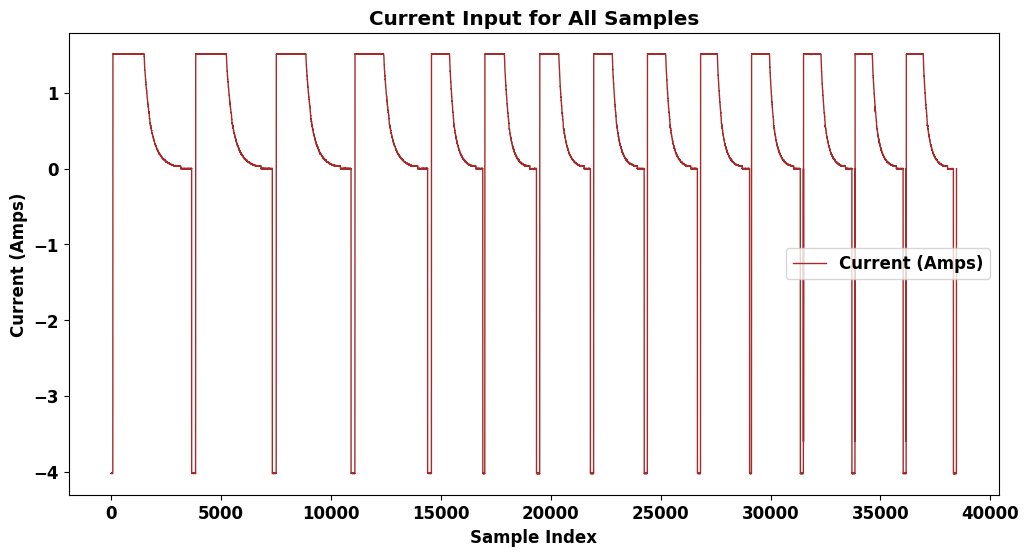

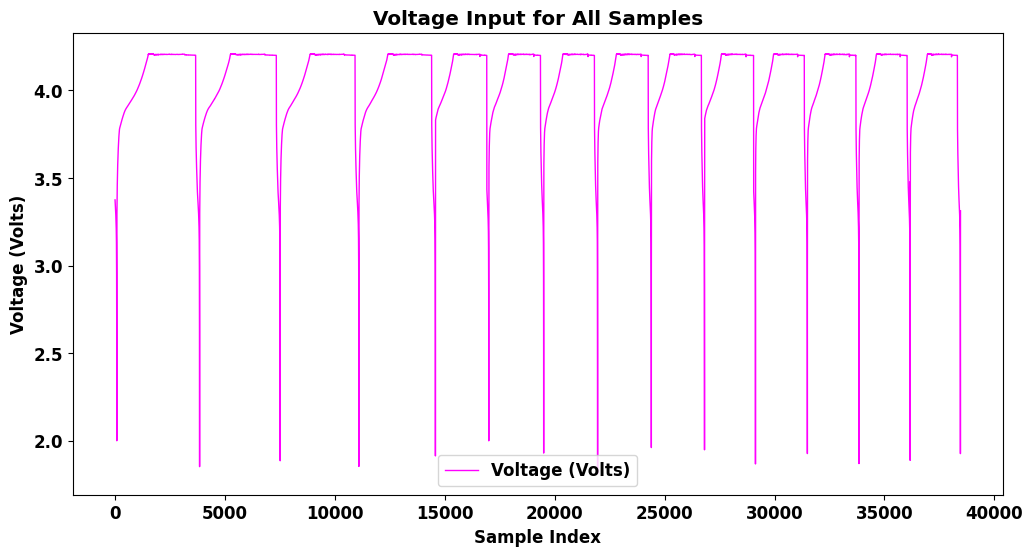

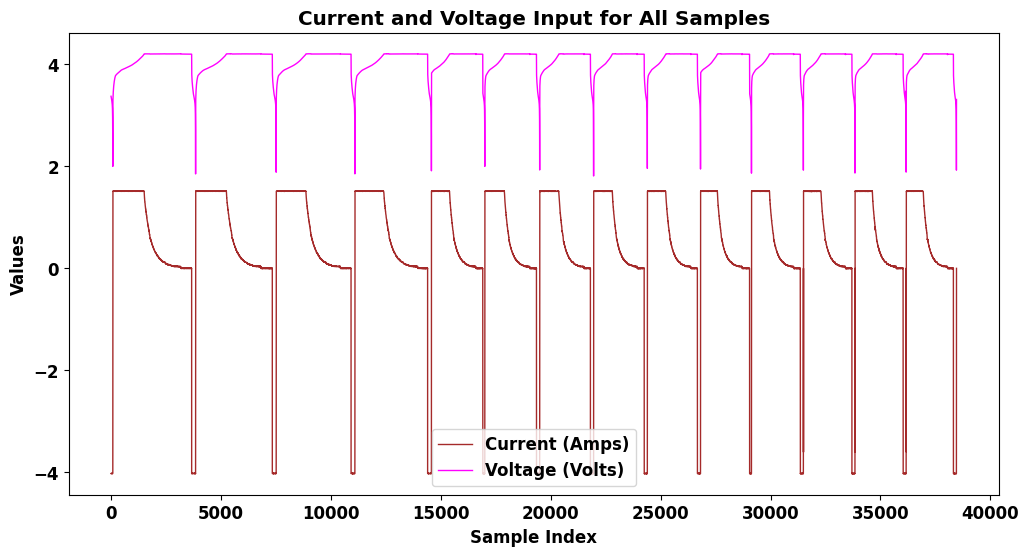

In [20]:
# -----------------------------
# Plot charts for a specific interval (e.g. samples 30 to 60),
# save the interval subset as an Excel file, and also plot the input charts 
# (voltage and current) for that interval including the 60 samples prior to it.
# -----------------------------

import os
import matplotlib.pyplot as plt

# Define the interval of interest (using the Sample_Index in comparison_df)
interval_start = 7000
interval_end = 8500

# Create a new folder for the interval plots and Excel file (e.g., "Interval_30_60")
interval_folder = os.path.join(directory_name, f"Interval_{interval_start}_{interval_end}")
if not os.path.exists(interval_folder):
    os.makedirs(interval_folder)

# --- Current Chart for All Samples ---
plt.figure(figsize=(12, 6))
plt.plot(comparison_df["Sample_Index"], comparison_df["Current"], label="Current (Amps)", color="brown", linewidth=1)
plt.title("Current Input for All Samples", fontweight='bold')
plt.xlabel("Sample Index", fontweight='bold')
plt.ylabel("Current (Amps)", fontweight='bold')
plt.legend()
plt.grid(False)

# Save and show the current plot
current_plot_path = os.path.join(interval_folder, "Current_All_Samples.png")
plt.savefig(current_plot_path, dpi=1000, bbox_inches='tight', pad_inches=0)
plt.show()

# --- Voltage Chart for All Samples ---
plt.figure(figsize=(12, 6))
plt.plot(comparison_df["Sample_Index"], comparison_df["Voltage"], label="Voltage (Volts)", color="magenta", linewidth=1)
plt.title("Voltage Input for All Samples", fontweight='bold')
plt.xlabel("Sample Index", fontweight='bold')
plt.ylabel("Voltage (Volts)", fontweight='bold')
plt.legend()
plt.grid(False)

# Save and show the voltage plot
voltage_plot_path = os.path.join(interval_folder, "Voltage_All_Samples.png")
plt.savefig(voltage_plot_path, dpi=1000, bbox_inches='tight', pad_inches=0)
plt.show()

# -----------------------------
# Combined Current and Voltage Plot
# -----------------------------
plt.figure(figsize=(12, 6))
plt.plot(comparison_df["Sample_Index"], comparison_df["Current"], label="Current (Amps)", color="brown", linewidth=1)
plt.plot(comparison_df["Sample_Index"], comparison_df["Voltage"], label="Voltage (Volts)", color="magenta", linewidth=1)
plt.title("Current and Voltage Input for All Samples", fontweight='bold')
plt.xlabel("Sample Index", fontweight='bold')
plt.ylabel("Values", fontweight='bold')
plt.legend()
plt.grid(False)

# Save and show the combined current & voltage plot
combined_plot_path = os.path.join(interval_folder, "Current_Voltage_All_Samples.png")
plt.savefig(combined_plot_path, dpi=1000, bbox_inches='tight', pad_inches=0)
plt.show()


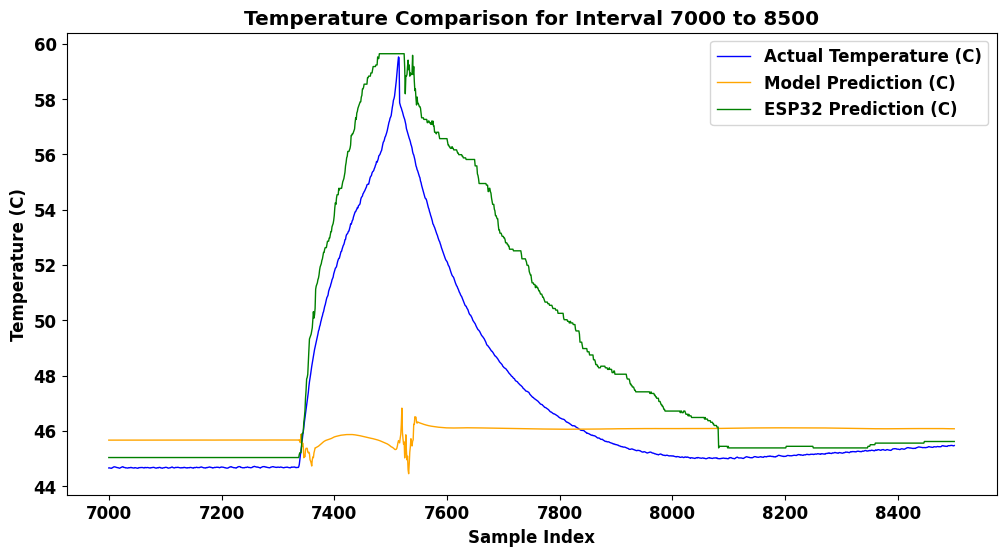

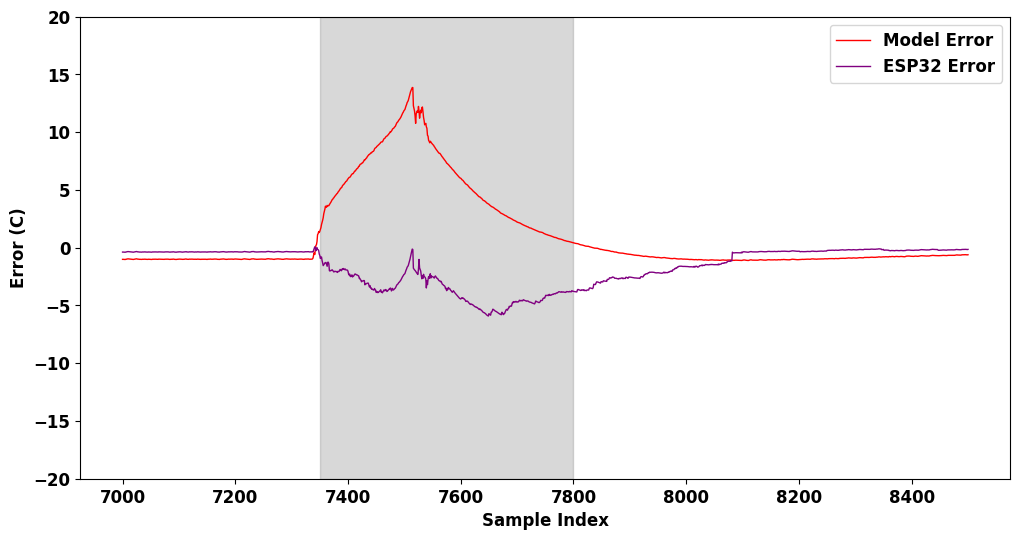

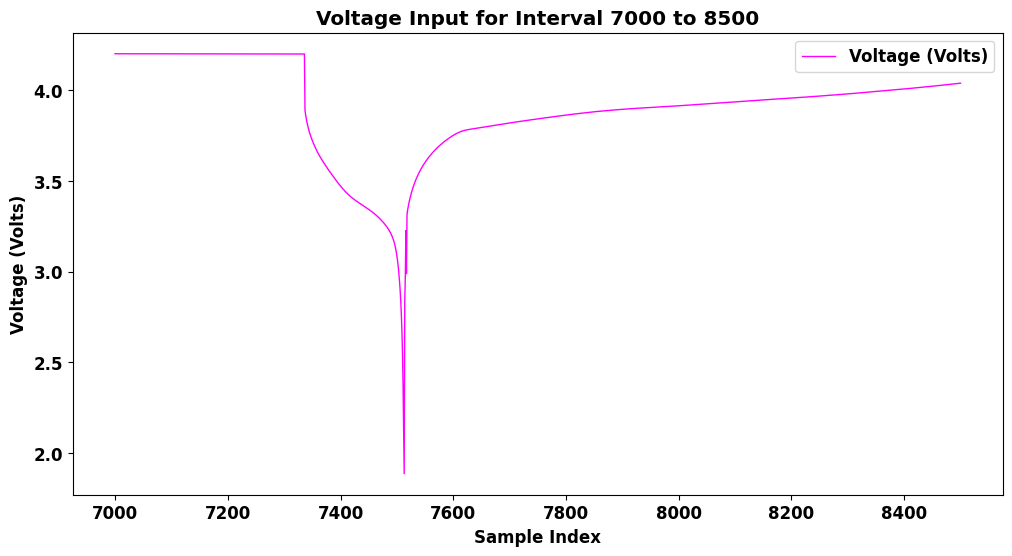

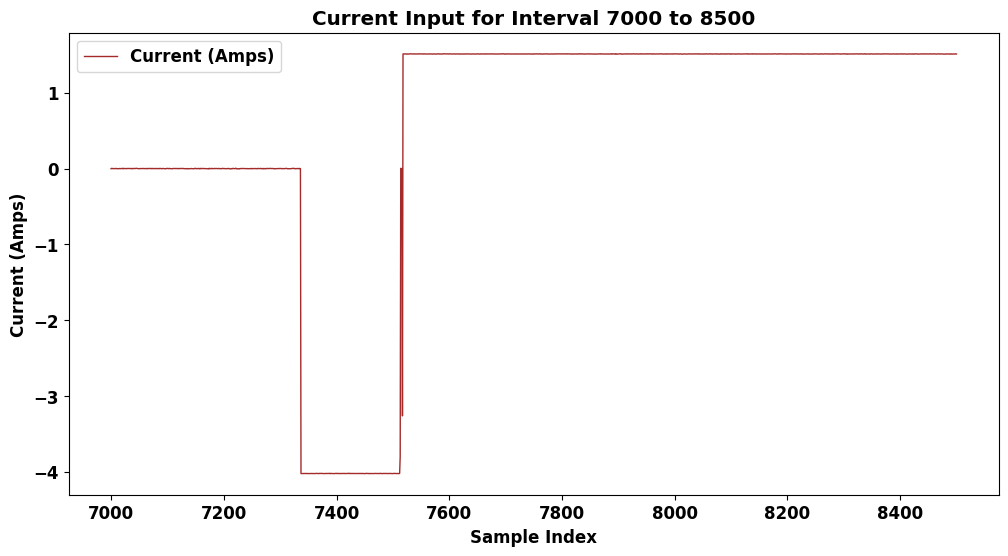

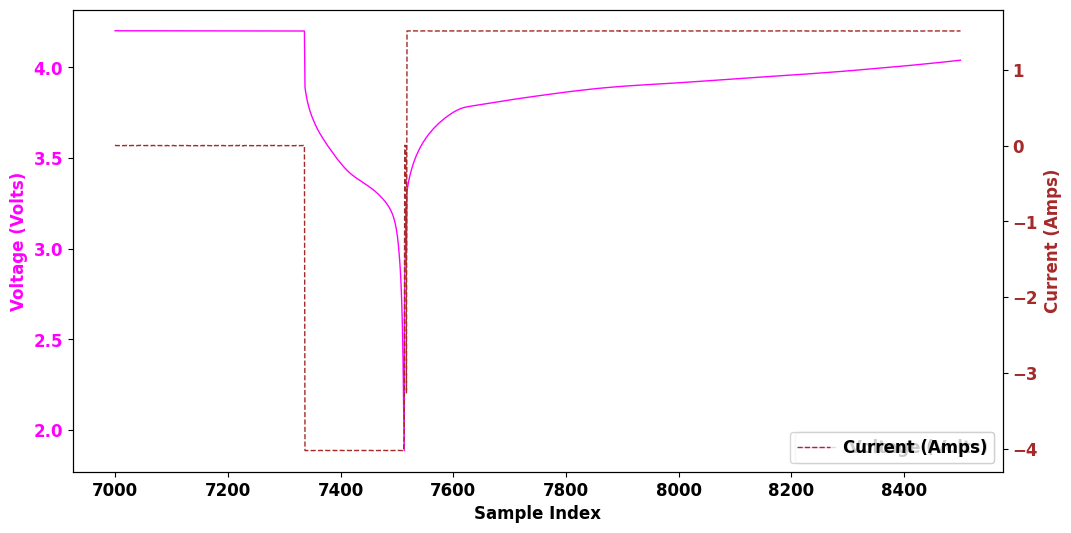

In [39]:
# Filter data for the specified interval
interval_df = comparison_df[(comparison_df["Sample_Index"] >= interval_start) &
                            (comparison_df["Sample_Index"] <= interval_end)]

# --- Temperature Comparison ---
plt.figure(figsize=(12, 6))
plt.plot(interval_df["Sample_Index"], interval_df["Actual (C)"], label="Actual Temperature (C)", color="blue", linewidth=1)
plt.plot(interval_df["Sample_Index"], interval_df["Model_Pred (C)"], label="Model Prediction (C)", color="orange", linewidth=1)
plt.plot(interval_df["Sample_Index"], interval_df["ESP_Pred (C)"], label="ESP32 Prediction (C)", color="green", linewidth=1)
plt.title(f"Temperature Comparison for Interval {interval_start} to {interval_end}", fontweight='bold')
plt.xlabel("Sample Index", fontweight='bold')
plt.ylabel("Temperature (C)", fontweight='bold')
plt.legend()
plt.grid(False)

# Save and show the temperature plot
temp_plot_path = os.path.join(interval_folder, f"Temperature_Interval_{interval_start}_{interval_end}.png")
plt.savefig(temp_plot_path, dpi=1000, bbox_inches='tight', pad_inches=0)
plt.show()

# --- Error Comparison ---
plt.figure(figsize=(12, 6))
plt.plot(interval_df["Sample_Index"], interval_df["Error_Model"], label="Model Error", color="red", linewidth=1)
plt.plot(interval_df["Sample_Index"], interval_df["Error_ESP"], label="ESP32 Error", color="purple", linewidth=1)
# plt.title(f"Error Comparison for Interval {interval_start} to {interval_end}", fontweight='bold')
plt.xlabel("Sample Index", fontweight='bold')
plt.ylabel("Error (C)", fontweight='bold')
plt.ylim(-20, 20)
plt.legend()
plt.grid(False)

# Highlight the shaded region (7350 to 7800)
plt.axvspan(7350, 7800, color='gray', alpha=0.3)  # Shaded area in gray

# Save and show the error plot
error_plot_path = os.path.join(interval_folder, f"Error_Interval_{interval_start}_{interval_end}.png")
plt.savefig(error_plot_path, dpi=1000, bbox_inches='tight', pad_inches=0)
plt.show()

# --- Voltage Plot ---
plt.figure(figsize=(12, 6))
plt.plot(interval_df["Sample_Index"], interval_df["Voltage"], label="Voltage (Volts)", color="magenta", linewidth=1)
plt.title(f"Voltage Input for Interval {interval_start} to {interval_end}", fontweight='bold')
plt.xlabel("Sample Index", fontweight='bold')
plt.ylabel("Voltage (Volts)", fontweight='bold')
plt.legend()
plt.grid(False)

# Save and show the voltage plot
voltage_plot_path = os.path.join(interval_folder, f"Voltage_Interval_{interval_start}_{interval_end}.png")
plt.savefig(voltage_plot_path, dpi=1000, bbox_inches='tight', pad_inches=0)
plt.show()

# --- Current Plot ---
plt.figure(figsize=(12, 6))
plt.plot(interval_df["Sample_Index"], interval_df["Current"], label="Current (Amps)", color="brown", linewidth=1)
plt.title(f"Current Input for Interval {interval_start} to {interval_end}", fontweight='bold')
plt.xlabel("Sample Index", fontweight='bold')
plt.ylabel("Current (Amps)", fontweight='bold')
plt.legend()
plt.grid(False)

# Save and show the current plot
current_plot_path = os.path.join(interval_folder, f"Current_Interval_{interval_start}_{interval_end}.png")
plt.savefig(current_plot_path, dpi=1000, bbox_inches='tight', pad_inches=0)
plt.show()

# -----------------------------------------------
# New Plot: Voltage and Current with Dual Y-Axis
# -----------------------------------------------
fig, ax1 = plt.subplots(figsize=(12, 6))

# Primary y-axis: Voltage plot
ax1.plot(interval_df["Sample_Index"], interval_df["Voltage"], label="Voltage (Volts)", color="magenta", linewidth=1)
ax1.set_xlabel("Sample Index", fontweight='bold')
ax1.set_ylabel("Voltage (Volts)", fontweight='bold', color="magenta")
ax1.tick_params(axis='y', labelcolor="magenta")
ax1.legend(loc="lower right")
ax1.grid(False)

# Secondary y-axis: Current plot
ax2 = ax1.twinx()  # Create a secondary y-axis
ax2.plot(interval_df["Sample_Index"], interval_df["Current"], label="Current (Amps)", color="brown", linestyle="dashed", linewidth=1)
ax2.set_ylabel("Current (Amps)", fontweight='bold', color="brown")
ax2.tick_params(axis='y', labelcolor="brown")
ax2.legend(loc="lower right")

# plt.title(f"Voltage and Current Overlay for Interval {interval_start} to {interval_end}", fontweight='bold')

# Save and display the plot
voltage_current_plot_path = os.path.join(interval_folder, f"Voltage_Current_Interval_{interval_start}_{interval_end}.png")
plt.savefig(voltage_current_plot_path, dpi=1000, bbox_inches='tight', pad_inches=0)
plt.show()





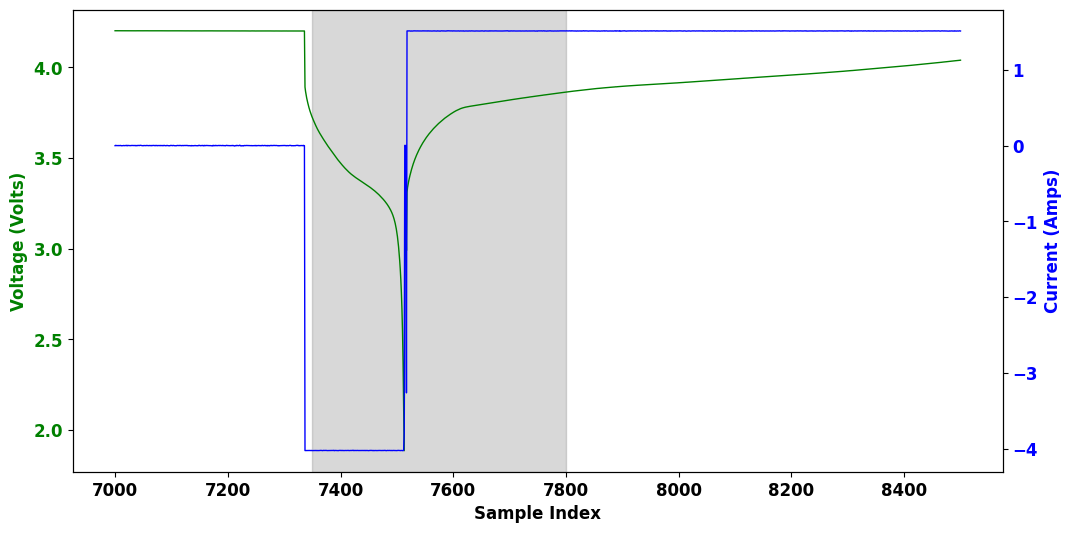

In [37]:
# -----------------------------------------------
# New Plot: Voltage and Current with Dual Y-Axis + Shaded Region
# -----------------------------------------------
fig, ax1 = plt.subplots(figsize=(12, 6))

# Primary y-axis: Voltage plot
ax1.plot(interval_df["Sample_Index"], interval_df["Voltage"], label="Voltage (Volts)", color="green", linewidth=1)
ax1.set_xlabel("Sample Index", fontweight='bold')
ax1.set_ylabel("Voltage (Volts)", fontweight='bold', color="green")
ax1.tick_params(axis='y', labelcolor="green")
# ax1.legend(loc="best")
ax1.grid(False)

# Secondary y-axis: Current plot
ax2 = ax1.twinx()  # Create a secondary y-axis
ax2.plot(interval_df["Sample_Index"], interval_df["Current"], label="Current (Amps)", color="blue", linewidth=1)
ax2.set_ylabel("Current (Amps)", fontweight='bold', color="blue")
ax2.tick_params(axis='y', labelcolor="blue")
# ax2.legend(loc="best")

# Highlight the shaded region (7350 to 7800)
ax1.axvspan(7350, 7800, color='gray', alpha=0.3)  # Shaded area in gray

# plt.title(f"Voltage and Current Overlay for Interval {interval_start} to {interval_end}\n(Highlighted Region: 7350 to 7800)", fontweight='bold')

# Save and display the plot
voltage_current_plot_path = os.path.join(interval_folder, f"Voltage_Current_Interval_{interval_start}_{interval_end}_Shaded.png")
plt.savefig(voltage_current_plot_path, dpi=1000, bbox_inches='tight', pad_inches=0)
plt.show()

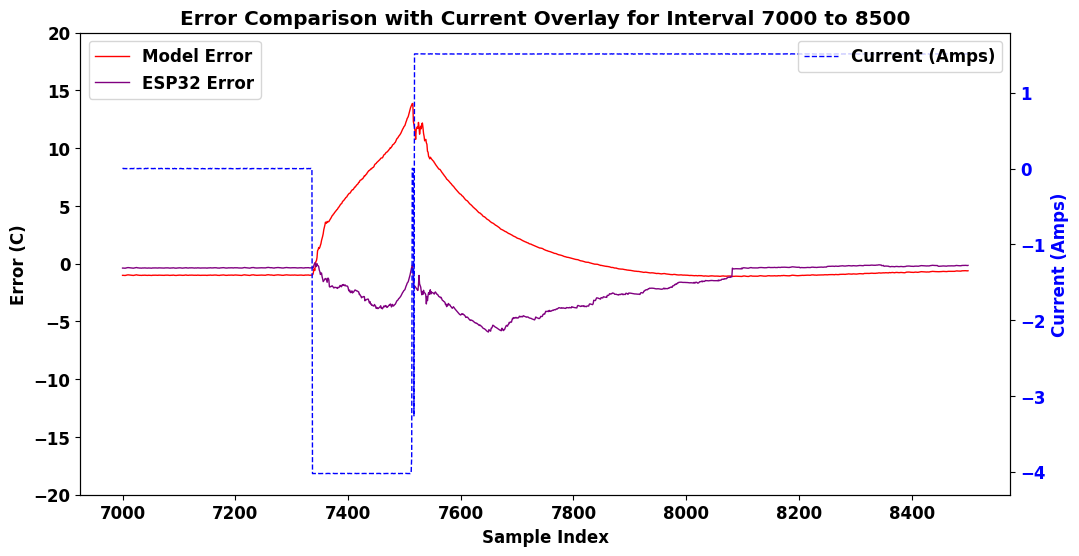

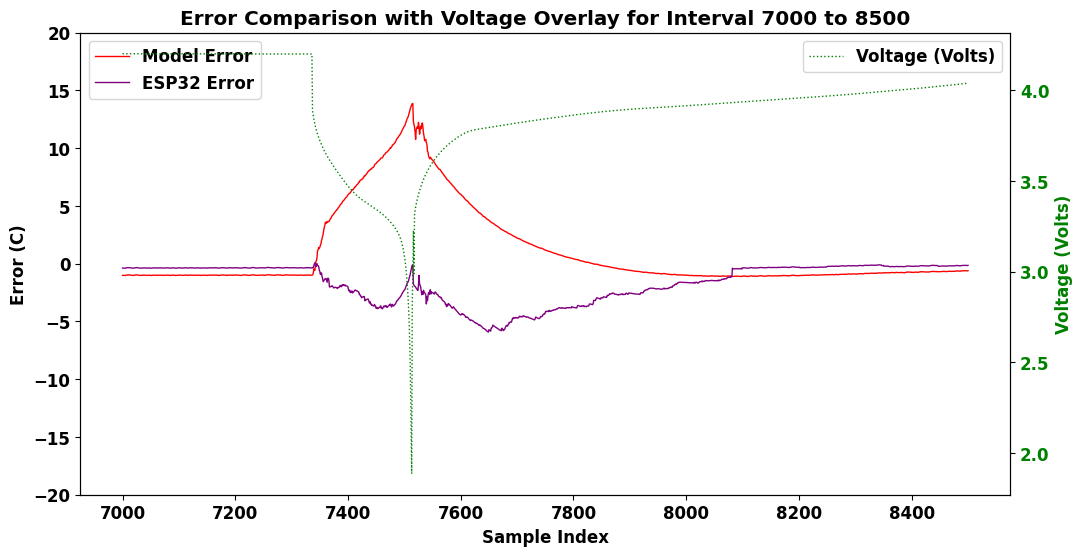

In [ ]:
# Create a figure with two y-axes for Error and Current
fig, ax1 = plt.subplots(figsize=(12, 6))

# Primary y-axis: Error plots
ax1.plot(interval_df["Sample_Index"], interval_df["Error_Model"], label="Model Error", color="red", linewidth=1)
ax1.plot(interval_df["Sample_Index"], interval_df["Error_ESP"], label="ESP32 Error", color="purple", linewidth=1)
ax1.set_xlabel("Sample Index", fontweight='bold')
ax1.set_ylabel("Error (C)", fontweight='bold', color="black")
ax1.set_ylim(-20, 20)
ax1.tick_params(axis='y', labelcolor="black")
ax1.legend(loc="upper left")
ax1.grid(False)

# Secondary y-axis: Current plot
ax2 = ax1.twinx()  # Create a secondary y-axis
ax2.plot(interval_df["Sample_Index"], interval_df["Current"], label="Current (Amps)", color="blue", linestyle="dashed", linewidth=1)
ax2.set_ylabel("Current (Amps)", fontweight='bold', color="blue")
ax2.tick_params(axis='y', labelcolor="blue")
ax2.legend(loc="upper right")

plt.title(f"Error Comparison with Current Overlay for Interval {interval_start} to {interval_end}", fontweight='bold')

# Save and display the plot
error_current_plot_path = os.path.join(interval_folder, f"Error_with_Current_Interval_{interval_start}_{interval_end}.png")
plt.savefig(error_current_plot_path, dpi=1000, bbox_inches='tight', pad_inches=0)
plt.show()

# -----------------------------------------------
# Add a new plot: Error with Voltage
# -----------------------------------------------

# Create a figure with two y-axes for Error and Voltage
fig, ax1 = plt.subplots(figsize=(12, 6))

# Primary y-axis: Error plots
ax1.plot(interval_df["Sample_Index"], interval_df["Error_Model"], label="Model Error", color="red", linewidth=1)
ax1.plot(interval_df["Sample_Index"], interval_df["Error_ESP"], label="ESP32 Error", color="purple", linewidth=1)
ax1.set_xlabel("Sample Index", fontweight='bold')
ax1.set_ylabel("Error (C)", fontweight='bold', color="black")
ax1.set_ylim(-20, 20)
ax1.tick_params(axis='y', labelcolor="black")
ax1.legend(loc="upper left")
ax1.grid(False)

# Secondary y-axis: Voltage plot
ax2 = ax1.twinx()  # Create a secondary y-axis
ax2.plot(interval_df["Sample_Index"], interval_df["Voltage"], label="Voltage (Volts)", color="green", linestyle="dotted", linewidth=1)
ax2.set_ylabel("Voltage (Volts)", fontweight='bold', color="green")
ax2.tick_params(axis='y', labelcolor="green")
ax2.legend(loc="upper right")

plt.title(f"Error Comparison with Voltage Overlay for Interval {interval_start} to {interval_end}", fontweight='bold')

# Save and display the plot
error_voltage_plot_path = os.path.join(interval_folder, f"Error_with_Voltage_Interval_{interval_start}_{interval_end}.png")
plt.savefig(error_voltage_plot_path, dpi=1000, bbox_inches='tight', pad_inches=0)
plt.show()


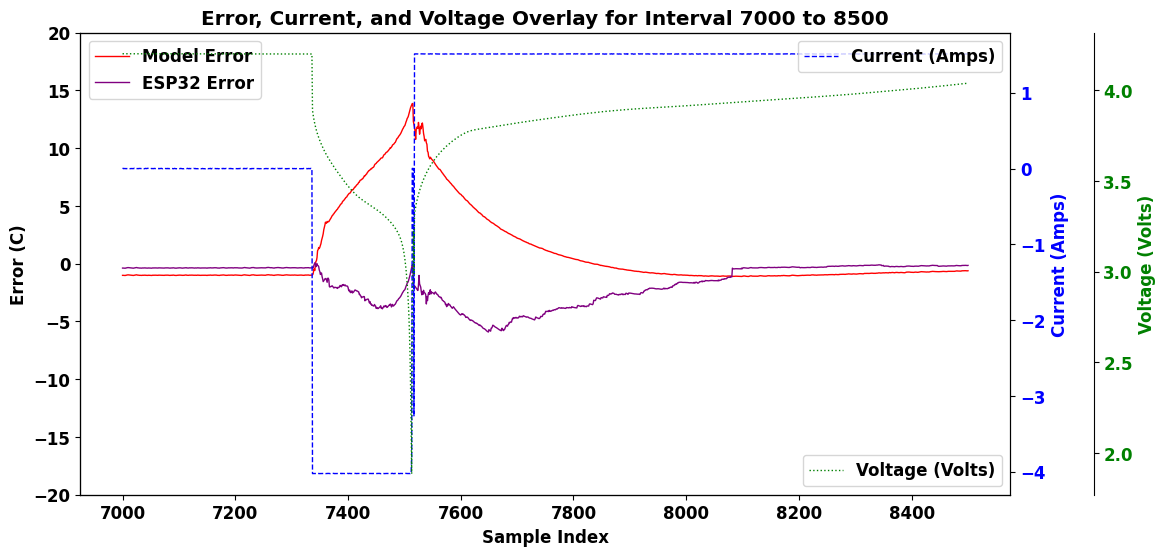

In [13]:
# Create a figure with multiple y-axes
fig, ax1 = plt.subplots(figsize=(12, 6))

# Primary y-axis: Error plots
ax1.plot(interval_df["Sample_Index"], interval_df["Error_Model"], label="Model Error", color="red", linewidth=1)
ax1.plot(interval_df["Sample_Index"], interval_df["Error_ESP"], label="ESP32 Error", color="purple", linewidth=1)
ax1.set_xlabel("Sample Index", fontweight='bold')
ax1.set_ylabel("Error (C)", fontweight='bold', color="black")
ax1.set_ylim(-20, 20)
ax1.tick_params(axis='y', labelcolor="black")
ax1.legend(loc="upper left")
ax1.grid(False)

# Secondary y-axis: Current plot
ax2 = ax1.twinx()  # Create a secondary y-axis
ax2.plot(interval_df["Sample_Index"], interval_df["Current"], label="Current (Amps)", color="blue", linestyle="dashed", linewidth=1)
ax2.set_ylabel("Current (Amps)", fontweight='bold', color="blue")
ax2.tick_params(axis='y', labelcolor="blue")
ax2.legend(loc="upper right")

# Third y-axis workaround: Voltage plot (scaled for better visibility)
ax3 = ax1.twinx()  # Reuse ax1 to create a third y-axis overlay
ax3.spines["right"].set_position(("outward", 60))  # Move the third y-axis outward for clarity
ax3.plot(interval_df["Sample_Index"], interval_df["Voltage"], label="Voltage (Volts)", color="green", linestyle="dotted", linewidth=1)
ax3.set_ylabel("Voltage (Volts)", fontweight='bold', color="green")
ax3.tick_params(axis='y', labelcolor="green")
ax3.legend(loc="lower right")

plt.title(f"Error, Current, and Voltage Overlay for Interval {interval_start} to {interval_end}", fontweight='bold')

# Save and display the plot
error_current_voltage_plot_path = os.path.join(interval_folder, f"Error_Current_Voltage_Interval_{interval_start}_{interval_end}.png")
plt.savefig(error_current_voltage_plot_path, dpi=1000, bbox_inches='tight', pad_inches=0)
plt.show()
